In [37]:
# error Analysis
import pandas as pd
import seaborn as sns
import os
import rasterio
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import mapclassify

# set parameters
root = "D:/ASOML/Rockies/"
modelRunRoot = "modelOutputs/fromAlpine/20250511_230947"
year = "2025"
errorRas = r"D:\ASOML\Rockies\modelOutputs\fromAlpine\20250511_230947\outTifs_G2_yPreds_tifs\mosaic_output\blendedOutput_mos_G2_MR20250511_230947_percentDiff.tif"

# folder paths
featureWorkspace = "D:/ASOML/Rockies/features/"
Tree = "D:/ASOML/Rockies/treeCover/"
LandCover = "D:/ASOML/Rockies/landCover/"
fSCA = r"D:\ASOML\Rockies\2025\fSCA\ClearCreek_2025099_albn83_60m_FSCA.tif"

# start processing 
features = []

for raster in os.listdir(featureWorkspace):
    if raster.endswith(".tif"):
        features.append(featureWorkspace + raster)

# add in the vegetation and landcover dataets
for tree in os.listdir(Tree):
    if tree.endswith(".tif"):
        if tree.startswith(year):
            features.append(Tree + tree)
            
for land in os.listdir(LandCover):
    if land.endswith(".tif"):
        if land.startswith(year):
            features.append(LandCover + land)

# add in fSCA
features.append(fSCA)

In [38]:
print(features)

['D:/ASOML/Rockies/features/ASOML_CON_stdElv_60_albn83.tif', 'D:/ASOML/Rockies/features/ASOML_CON_waterbodies_1_0_60_albn83.tif', 'D:/ASOML/Rockies/features/ASOML_CON_windScour_60_albn83.tif', 'D:/ASOML/Rockies/features/ASO_CON_aspect_albn83_60m.tif', 'D:/ASOML/Rockies/features/ASO_CON_curv_albn83_60m.tif', 'D:/ASOML/Rockies/features/ASO_CON_dem_albn83_60m.tif', 'D:/ASOML/Rockies/features/ASO_CON_GausCurv_albn83_60m.tif', 'D:/ASOML/Rockies/features/ASO_CON_gradMag_60_albn83.tif', 'D:/ASOML/Rockies/features/ASO_CON_lat_albn83_60m.tif', 'D:/ASOML/Rockies/features/ASO_CON_lon_albn83_60m.tif', 'D:/ASOML/Rockies/features/ASO_CON_PlanCurv_albn83_60m.tif', 'D:/ASOML/Rockies/features/ASO_CON_ProCurv_albn83_60m.tif', 'D:/ASOML/Rockies/features/ASO_CON_slope_albn83_60m.tif', 'D:/ASOML/Rockies/features/ASO_CON_STDslope_albn83_60m.tif', 'D:/ASOML/Rockies/features/ASO_CON_TPI_albn83_60m.tif', 'D:/ASOML/Rockies/treeCover/2025_rcmap_NLCD_albn83_60_extr_null.tif', 'D:/ASOML/Rockies/landCover/2025_NLCD

Skipping ASOML_CON_waterbodies_1_0_60_albn83 due to shape mismatch
Skipping ClearCreek_2025099_albn83_60m_FSCA due to shape mismatch


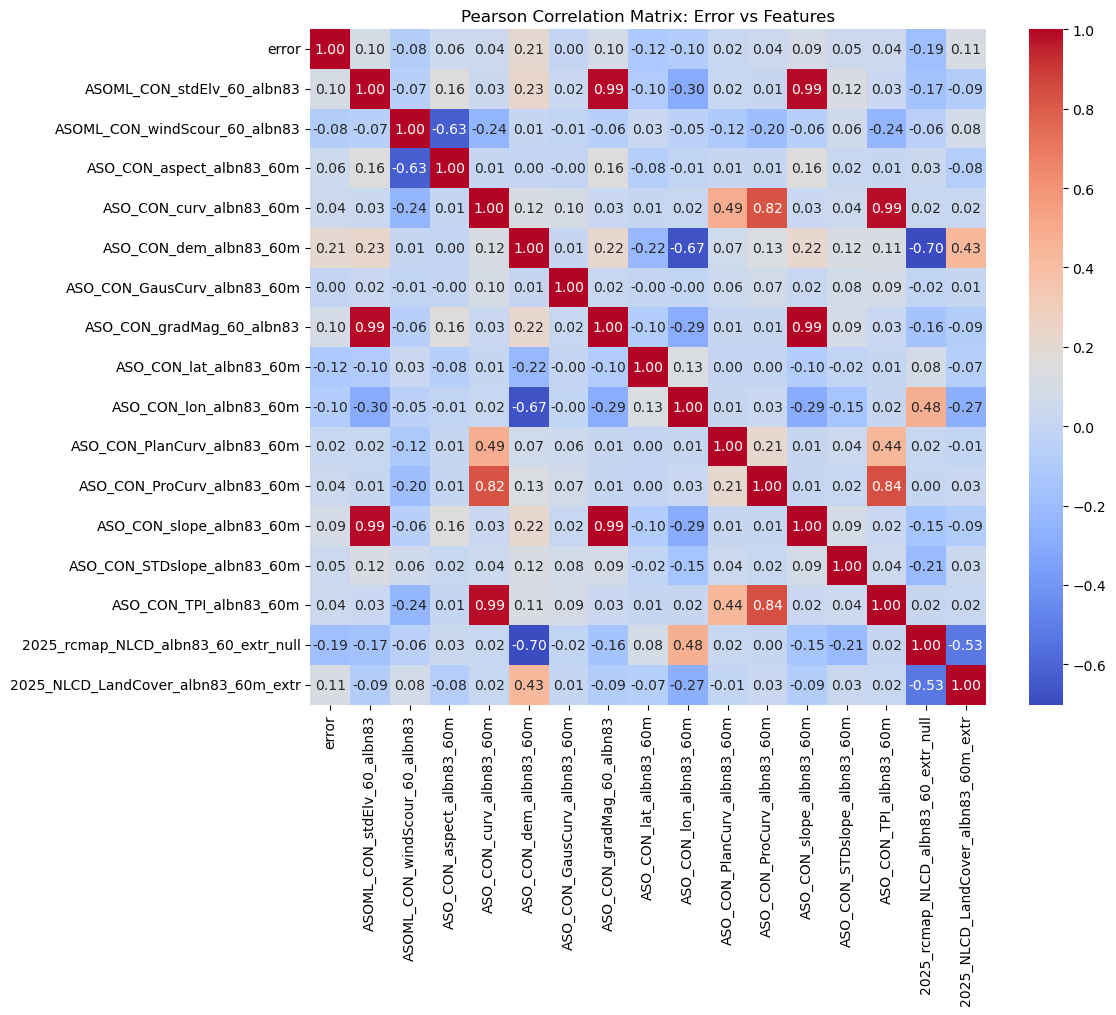

In [41]:
# --- Load error raster ---
with rasterio.open(errorRas) as err_src:
    error = err_src.read(1).astype(float)
    err_bounds = err_src.bounds
    err_transform = err_src.transform
    err_crs = err_src.crs
    err_nodata = err_src.nodata
    if err_nodata is not None:
        error[error == err_nodata] = np.nan

# --- Data collection ---
data = {'error': error.flatten()}
valid_mask = ~np.isnan(error)

# --- Loop through features ---
for feat_path in features:
    name = os.path.basename(feat_path).replace(".tif", "")
    with rasterio.open(feat_path) as feat_src:
        window = from_bounds(*err_bounds, transform=feat_src.transform)
        feature = feat_src.read(1, window=window).astype(float)
        if feat_src.nodata is not None:
            feature[feature == feat_src.nodata] = np.nan

    if feature.shape != error.shape:
        print(f"Skipping {name} due to shape mismatch")
        continue

    # Update mask to remove NaNs from this feature
    valid_mask &= ~np.isnan(feature)
    data[name] = feature.flatten()

# --- Build DataFrame ---
df = pd.DataFrame(data)
df = df[valid_mask.flatten()]  # apply combined valid mask

# --- Pearson correlation matrix ---
corr_matrix = df.corr(method='pearson')

# --- Save and visualize ---
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Pearson Correlation Matrix: Error vs Features")
plt.tight_layout()
# plt.savefig(os.path.join(root, modelRunRoot, "error_feature_correlation_matrix.png"), dpi=200)
plt.show()